In [1]:
# notebooks/01_quickstart.ipynb
from obp.dataset import OpenBanditDataset
from obp.policy import BernoulliTS
from obp.ope import OffPolicyEvaluation, InverseProbabilityWeighting as IPW


### Load the logs from Zozotown
For each visitor, the site showed 3 random items out of thousands (note that behavior policy selected is random)


In [3]:

ds = OpenBanditDataset(behavior_policy="random", campaign="all")

INFO:obp.dataset.real:When `data_path` is not given, this class downloads the small-sized version of Open Bandit Dataset.


In [6]:
bf = ds.obtain_batch_bandit_feedback()
import pandas as pd

df = pd.DataFrame({
    "action": bf["action"],
    "position": bf["position"],
    "reward": bf["reward"],
    "pscore": bf["pscore"],
})
df

,action,position,reward,pscore
0,14,2,0,0.0125
1,14,2,0,0.0125
2,27,2,0,0.0125
3,48,1,0,0.0125
4,36,1,0,0.0125
...,...,...,...,...
9995,2,1,0,0.0125
9996,45,1,0,0.0125
9997,32,2,0,0.0125
9998,13,1,0,0.0125


In [7]:
# Calculate average reward per action per position
avg_reward_per_action_position = df.groupby(['position', 'action'])['reward'].mean().reset_index()
avg_reward_per_action_position.columns = ['position', 'action', 'avg_reward']
avg_reward_per_action_position

,position,action,avg_reward
0,0,0,0.00
1,0,1,0.02
2,0,2,0.00
3,0,3,0.00
4,0,4,0.00
...,...,...,...
235,2,75,0.00
236,2,76,0.00
237,2,77,0.00
238,2,78,0.00


In [10]:
# Calculate average reward per action, including all possible actions
avg_reward_per_action = df.groupby(['action'])['reward'].agg(['mean', 'count']).reset_index()
avg_reward_per_action.columns = ['action', 'avg_reward', 'num_observations']

# Create a complete range of all possible actions (0 to max action)
all_actions = pd.DataFrame({'action': range(ds.n_actions)})

# Merge to include all actions, even those not in the data
avg_reward_per_action_complete = all_actions.merge(avg_reward_per_action, on='action', how='left')

# Mark actions with no data as NaN (not 0)
avg_reward_per_action_complete['has_data'] = avg_reward_per_action_complete['num_observations'].notna()
avg_reward_per_action_complete['avg_reward'] = avg_reward_per_action_complete['avg_reward'].fillna(0)
avg_reward_per_action_complete['num_observations'] = avg_reward_per_action_complete['num_observations'].fillna(0).astype(int)

avg_reward_per_action_complete

,action,avg_reward,num_observations,has_data
0,0,0.000000,122,True
1,1,0.006250,160,True
2,2,0.000000,131,True
3,3,0.007937,126,True
4,4,0.000000,121,True
...,...,...,...,...
75,75,0.000000,127,True
76,76,0.000000,122,True
77,77,0.000000,108,True
78,78,0.000000,134,True


In [14]:
import plotly.express as px

# Sort by action to ensure proper ordering
avg_reward_per_action_complete = avg_reward_per_action_complete.sort_values('action').reset_index(drop=True)

# Add a label column to differentiate between zero CTR and no data
avg_reward_per_action_complete['data_status'] = avg_reward_per_action_complete.apply(
    lambda row: 'No Data' if not row['has_data'] else ('Zero CTR' if row['avg_reward'] == 0 else 'Has CTR'),
    axis=1
)

# Plot average reward per action with color coding
fig = px.bar(avg_reward_per_action_complete, 
             x='action', 
             y='avg_reward',
             color='data_status',
             title='Average Reward per Action (All Actions Shown)',
             labels={'action': 'Action ID', 'avg_reward': 'Average Reward', 'data_status': 'Data Status'},
             height=500,
             color_discrete_map={'Has CTR': '#636EFA', 'Zero CTR': '#EF553B', 'No Data': '#CCCCCC'},
             hover_data=['num_observations'])
fig.update_layout(showlegend=True)
fig.update_xaxes(type='linear', dtick=1)  # Ensure actions are shown in numeric order
fig.show()

In [16]:
print("Average CTR:", bf["reward"].mean())
print("Unique items recommended:", len(set(bf["action"])))
print("Position counts:", pd.Series(bf["position"]).value_counts())

Average CTR: 0.0038
Unique items recommended: 80
Position counts: 1    3412
0    3322
2    3266
dtype: int64


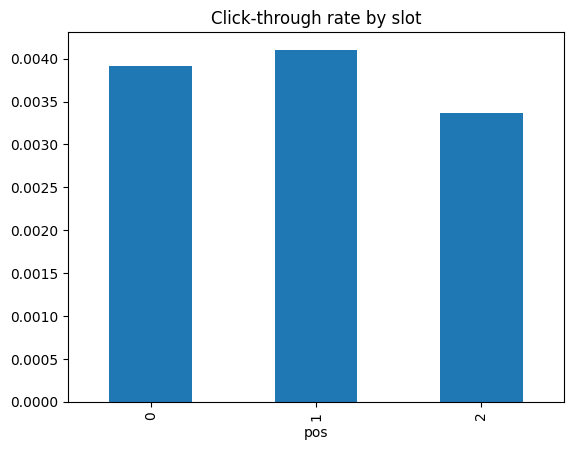

In [17]:
import matplotlib.pyplot as plt

pos_ctr = pd.DataFrame({"pos": bf["position"], "click": bf["reward"]}).groupby("pos").mean()
pos_ctr.plot(kind="bar", legend=False, title="Click-through rate by slot")
plt.show()

In [18]:
pos_ctr

,click
pos,
0,0.003913
1,0.004103
2,0.003368


In [11]:

# evaluation policy distribution over actions per round (factorized by position)
pi_e = BernoulliTS(
    n_actions=ds.n_actions, len_list=ds.len_list,
    is_zozotown_prior=True, campaign="all", random_state=123
)
action_dist = pi_e.compute_batch_action_dist(
    n_sim=100_000, n_rounds=bf["n_rounds"]
)

ope = OffPolicyEvaluation(bandit_feedback=bf, ope_estimators=[IPW()])
est = ope.estimate_policy_values(action_dist=action_dist)
print("IPW estimate:", est["ipw"])
print("Logged avg reward:", bf["reward"].mean())
print("Relative (IPW/logged):", est["ipw"] / bf["reward"].mean())

IPW estimate: 0.0045831199999999996
Logged avg reward: 0.0038
Relative (IPW/logged): 1.2060842105263156


### Making Sure the CTRs match using CSV vs OpenBanditDataset class 

In [19]:
# CSV (Random/all)
csv = pd.read_csv("zr-obp/obd/random/all/all.csv", index_col=0)
csv["pos0"] = csv["position"] - 1
ctr_csv = csv.groupby("pos0")["click"].mean().rename("ctr_csv")

# OBP loader (Random/all)
ds = OpenBanditDataset(behavior_policy="random", campaign="all")
bf = ds.obtain_batch_bandit_feedback()
ctr_bf = (pd.DataFrame({"pos0": bf["position"], "click": bf["reward"]})
          .groupby("pos0")["click"].mean().rename("ctr_bf"))

print(pd.concat([ctr_csv, ctr_bf], axis=1))

INFO:obp.dataset.real:When `data_path` is not given, this class downloads the small-sized version of Open Bandit Dataset.


       ctr_csv    ctr_bf
pos0                    
0     0.003913  0.003913
1     0.004103  0.004103
2     0.003368  0.003368
